In [1]:
#prepare dataset
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np
import shap
import pandas as pd

batch_size = 128
device = torch.device('cpu')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)


/Users/ericliu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [140]:
#Simple Row/Column RNN
class rowRNN(nn.Module):
    def __init__(self):
        super(rowRNN, self).__init__()
        self.rnn_row=nn.GRU(28,16,3,batch_first=True)
        self.clf=nn.Sequential(
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        out1,h1=self.rnn_row(x.squeeze(1))
        return self.clf(h1[-1])

    
#RNN w attention
class RNN_wAttn(nn.Module):
    def __init__(self):
        super(RNN_wAttn, self).__init__()
        self.rnn_row=nn.LSTM(28,16,2,bidirectional=True,batch_first=True)
        self.rnn_col=nn.LSTM(28,16,2,bidirectional=True,batch_first=True)
        self.clf=nn.Sequential(
            nn.ReLU(),
            nn.Linear(16+16, 10),
            nn.Softmax(dim=1)
        )
        
        
    def attention(self, rnn_out, last_hidden):
        w = torch.bmm(rnn_out, last_hidden)
        w = F.softmax(w.squeeze(2), dim=1).unsqueeze(2)
        return torch.bmm(torch.transpose(rnn_out, 1, 2), w).squeeze(2), w
        #return torch.bmm(torch.transpose(rnn_out, 1, 2), w).squeeze(2)

    def forward(self, x):
        out1,(h1,_)=self.rnn_row(x.squeeze(1))
        out1=torch.cat([out1[:,:,:16].unsqueeze(-1),out1[:,:,16:].unsqueeze(-1)],dim=-1).mean(dim=-1)
        h1=torch.cat([h1[-1].unsqueeze(-1),h1[-2].unsqueeze(-1)],dim=-1).mean(dim=-1)
        row_attn_output = self.attention(out1, h1.unsqueeze(-1))
        row_attn_output,row_w = self.attention(out1, h1.unsqueeze(-1))
        
        out2,(h2,_)=self.rnn_col(x.squeeze(1).transpose(1,2))
        out2=torch.cat([out2[:,:,:16].unsqueeze(-1),out2[:,:,16:].unsqueeze(-1)],dim=-1).mean(dim=-1)
        h2=torch.cat([h2[-1].unsqueeze(-1),h2[-2].unsqueeze(-1)],dim=-1).mean(dim=-1)
        col_attn_output = self.attention(out2, h2.unsqueeze(-1))
        col_attn_output,col_w = self.attention(out2, h2.unsqueeze(-1))  
        return self.clf(torch.cat([row_attn_output,col_attn_output],dim=1)), torch.bmm(row_w,col_w.transpose(1,2))
    


In [141]:
#train RNN w attention

def train_RNN(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output,_ = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()

def test_RNN(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,_ = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))





In [142]:
model = RNN_wAttn().to(device)
#model = rowRNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train_RNN(model, device, train_loader, optimizer, epoch)
    test_RNN(model, device, test_loader, epoch)

Epoch: 1 Test set: Average loss: 0.0011, Accuracy: 9614/10000 (96%)

Epoch: 2 Test set: Average loss: 0.0008, Accuracy: 9691/10000 (97%)

Epoch: 3 Test set: Average loss: 0.0005, Accuracy: 9769/10000 (98%)

Epoch: 4 Test set: Average loss: 0.0005, Accuracy: 9795/10000 (98%)

Epoch: 5 Test set: Average loss: 0.0005, Accuracy: 9827/10000 (98%)



In [44]:
#utilities
import math
from torch.autograd import Variable
from torch.nn import Parameter
from torch import linalg as LA
import torch.nn.init as init

logsqrt2pi=0.5 * np.log(2 * np.pi)

def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv1d:
        init.xavier_normal_(layer.weight)

def softclip(tensor, min_v):
    result_tensor = min_v + F.softplus(tensor - min_v)
    return result_tensor

def hard_sigmoid(logits):
    y_soft = torch.sigmoid(logits)
    index = (y_soft>=0.5).long()
    y_hard = torch.ones_like(logits, memory_format = torch.legacy_contiguous_format)*index
    return y_hard - y_soft.detach() + y_soft

def nll_gauss(mu, log_sigma, x):
    return 0.5 * torch.pow((x - mu) / log_sigma.exp(), 2) + log_sigma + logsqrt2pi

def kld_guass_exact(mu1, logvar1, mu2, logvar2, ):
    kld = logvar2-logvar1+(logvar1.exp()+(mu1-mu2)**2)/logvar2.exp()-1
    return 0.5*kld.sum(-1)

def kld_standardnormal_exact(logvar, mu):
    kld = mu.pow(2)+logvar.exp()-logvar-1
    return 0.5*kld.sum(-1)

#keep batch dim
def sigma_nll(x_hat, x):
    log_sigma = ((x - x_hat) ** 2).mean(dim=1,keepdim=True).sqrt().log()
    log_sigma = softclip(log_sigma, -6)
    return nll_gauss(x_hat, log_sigma, x).sum(-1)



In [45]:
#VRNN
class VRNN(nn.Module):
    def __init__(self, input_dim=28, rnn_h_dim=8, rnn_n_layers=2, z_dim=8, rnn_dropout=0.0,  rnn_bias = False, model_type=None):
        super(VRNN, self).__init__()
        self.input_dim=input_dim
        self.rnn_h_dim=rnn_h_dim
        self.rnn_n_layers=rnn_n_layers
        self.z_dim=z_dim
        self.model_type=model_type
        self.rnn_dropout=rnn_dropout
        self.rnn_bias = rnn_bias

        self.rnn_input_dim = self.input_dim
        self.rnn = nn.GRU(self.rnn_input_dim+self.z_dim, self.rnn_h_dim, self.rnn_n_layers, self.rnn_bias, batch_first = True)

        #clf
        self.clf = nn.Sequential(
            nn.Linear(self.z_dim, 10),
            nn.LogSoftmax(dim=1)
        )

        #prior based on h(t-1)
        self.prior_mean = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.rnn_h_dim, self.z_dim)
            )
        self.prior_logvar = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.rnn_h_dim, self.z_dim)
            )

        #encoder based on x(t) and h(t-1)
        self.enc_mean = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.input_dim+self.rnn_h_dim, self.rnn_h_dim),
            nn.ReLU(),
            nn.Linear(self.rnn_h_dim, self.z_dim)
            )
        self.enc_logvar = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.input_dim+self.rnn_h_dim, self.rnn_h_dim),
            nn.ReLU(),
            nn.Linear(self.rnn_h_dim, self.z_dim)
            )

        #decoder based on z(t) and h(t-1)
        self.dec_mean = nn.Sequential(
            nn.Linear(self.rnn_h_dim+self.z_dim, self.rnn_h_dim*2),
            #nn.BatchNorm1d(self.rnn_h_dim*2),
            nn.ReLU(),
            nn.Linear(self.rnn_h_dim*2,  self.input_dim)
            )

        #init
        self.clf.apply(init_weights)
        self.prior_mean.apply(init_weights)
        self.prior_logvar.apply(init_weights)
        self.enc_mean.apply(init_weights)
        self.enc_logvar.apply(init_weights)
        self.dec_mean.apply(init_weights)


    def weight_sum(self):
        w=self.get_weights()
        return sum([w[k] for k in w.keys()])

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu+eps.mul(std)

    #sample size n
    def sample_z(self, n, device):
        sample = torch.randn(n, self.rnn_h_dim+self.z_dim).to(device)
        return self.decode(sample)    

    #input shape: [batch_size, seq_len, input_dim]
    def forward(self, x, is_train=False):
        # vrnn init
        batch_size,max_len = x.shape[0], x.shape[1]
        kld_loss,nll_loss = 0,0
        x_recon,y_pred=[],[]
        logvars,encmean=[],[]
        h = Variable(torch.zeros(self.rnn_n_layers,batch_size , self.rnn_h_dim)).to(x.device)

        for t in range(max_len):
            #prior
            prior_mean_t=self.prior_mean(h[-1])
            prior_logvar_t=self.prior_logvar(h[-1])

            x_t = x[:,t,:]
            #encoder
            enc_x = torch.cat([x_t, h[-1]], 1)
            enc_mean_t = self.enc_mean(enc_x)
            enc_logvar_t = self.enc_logvar(enc_x)
            logvars.append(enc_logvar_t)
            encmean.append(enc_mean_t)
            #z, reparameterization
            z_t=self.reparameterize(enc_mean_t, enc_logvar_t)
            if is_train:
                y_pred.append(self.clf(z_t))
            else:
                y_pred.append(self.clf(enc_mean_t))
            

            dec_x = torch.cat([z_t, h[-1]], 1)
            dec_mean_t = self.dec_mean(dec_x)
            x_recon.append(dec_mean_t)

            # recurrence
            _, h = self.rnn(torch.cat([x_t, z_t], 1).unsqueeze(1), h)

            kld_t=kld_guass_exact(enc_mean_t, enc_logvar_t, prior_mean_t, prior_logvar_t)
            nll_t=sigma_nll(dec_mean_t, x_t)

            kld_loss+=(kld_t.sum())
            nll_loss+=(nll_t.sum())
        
        res={}
        res['kld_loss']=kld_loss
        res['nll_loss']=nll_loss
        res['y_score']=torch.stack(y_pred).transpose(0,1)
        res['x_recon']=torch.stack(x_recon).transpose(0,1)
        res['logvar']=torch.stack(logvars).transpose(0,1)
        res['encmean']=torch.stack(encmean).transpose(0,1)
        return res

In [46]:
#train VRNN
reconcriterion=nn.MSELoss()

def train_vRNN(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data=data.squeeze(1)
        data, target = data.to(device), target.to(device)
        N=len(data)*28
        optimizer.zero_grad()
        res_dict = model(data,is_train=True)
        x_recon = res_dict['x_recon']
        loss=F.nll_loss(res_dict['y_score'][:,-1,:], target)
        reconloss=torch.sqrt(reconcriterion(x_recon,data))
        loss += (res_dict['kld_loss']+torch.clamp(res_dict['nll_loss'], min=-10.0, max=10.0))/N + reconloss 
        loss.backward()
        optimizer.step()
        
        
def test_vRNN(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data=data.squeeze(1)
            data, target = data.to(device), target.to(device)
            res_dict = model(data)
            x_recon = res_dict['x_recon']
            y_pred = res_dict['y_score'][:,-1,:]
            test_loss += F.nll_loss(y_pred, target).item() # sum up batch loss
            pred = res_dict['y_score'][:,-1,:].max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Epoch: {} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    return  correct / len(test_loader.dataset)

In [47]:
num_epochs = 15
vmodel=VRNN(input_dim=28, rnn_h_dim=16, rnn_n_layers=2, z_dim=16)
optimizer = optim.Adam(vmodel.parameters(), lr=0.003)
for epoch in range(1, num_epochs + 1):
    train_vRNN(vmodel, device, train_loader, optimizer, epoch)
    acc=test_vRNN(vmodel, device, test_loader, epoch)

Epoch: 1 Test set: Average loss: 0.0124, Accuracy: 4043/10000 (40%)

Epoch: 2 Test set: Average loss: 0.0064, Accuracy: 6874/10000 (69%)

Epoch: 3 Test set: Average loss: 0.0041, Accuracy: 8238/10000 (82%)

Epoch: 4 Test set: Average loss: 0.0031, Accuracy: 8973/10000 (90%)

Epoch: 5 Test set: Average loss: 0.0021, Accuracy: 9316/10000 (93%)

Epoch: 6 Test set: Average loss: 0.0021, Accuracy: 9299/10000 (93%)

Epoch: 7 Test set: Average loss: 0.0017, Accuracy: 9495/10000 (95%)



KeyboardInterrupt: 

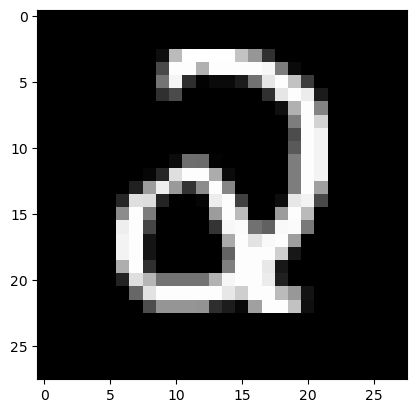

In [388]:
#Gaussian blur + random noise
example_batch=next(iter(test_loader))
example_images, _ = example_batch

fig=plt.figure()
plt.imshow(example_images[0].squeeze(),cmap='gray')
plt.show()


In [401]:
print(example_images[0].shape)
from torchvision.transforms import v2
#[channel, h, w]
def gaussian_blur(image):
    blurrer=v2.GaussianBlur(kernel_size=(5,5),sigma=(0.1,5))
    blrimgs=[blurrer(image) for _ in range(10)]
    return blrimgs[-1]
    

def gaussian_random_upper(x):
    image=torch.clone(x)
    up_img=gaussian_blur(image[:,4:15,:])
    eps=torch.rand(up_img.shape)*0.5
    up_img= (up_img+eps)>0.5
    image[:,4:15,:]= torch.clip(up_img, min=0., max=1.)
    
    return image
    
def gaussian_random_left(x):
    image=torch.clone(x)
    l_img=gaussian_blur(image[:,:,4:15])
    eps=torch.rand(l_img.shape)*0.5
    l_img= (l_img+eps)>0.5
    image[:,:,4:15]= torch.clip(l_img, min=0., max=1.)
    image[:,:2,:]=0
    image[:,26:,:]=0
    return image


torch.Size([1, 28, 28])


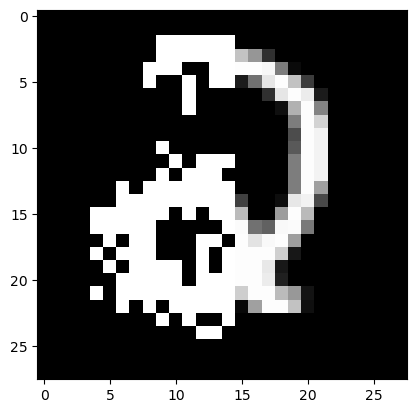

In [402]:
#right half blurred images
limg = gaussian_random_left(example_images[0])
fig=plt.figure()
plt.imshow(limg.squeeze(),cmap='gray')
plt.show()

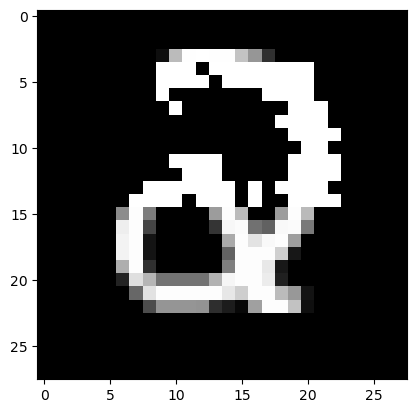

In [403]:
#upper half blurred images
upimg = gaussian_random_upper(example_images[0])
fig=plt.figure()
plt.imshow(upimg.squeeze(),cmap='gray')
plt.show()

In [404]:
#variance wrapper
from torch.autograd import grad,Variable
def get_derivative(model,z):
    z=Variable(z,requires_grad=True)
    y=model.clf(z)
    #y_z=grad(y,z,grad_outputs=torch.ones_like(y),create_graph=True)
    y_z=[grad(y[:,i],z,grad_outputs=torch.ones_like(y[:,i]),create_graph=True)[0] for i in range(10)]
    return (torch.stack(y_z)**2).transpose(0,2).transpose(0,1)


def gettotal_var(model,x):
    x=x.squeeze(1)
    res=model(x)
    z=res['encmean'][:,-1,:]
    y_z=get_derivative(model,z)
    total_var=torch.bmm(res['logvar'][:,-1,:].exp().unsqueeze(1),y_z)
    return total_var.squeeze(1)


class variance_wrapper_delta(nn.Module):
    def __init__(self, model):
        super(variance_wrapper_delta,self).__init__()
        self.model=model

    #z: [bs,z_dim]
    #y: [bs,10]
    #out [bs,z_dim, 10]
    def get_derivative(self,z):
        z=Variable(z,requires_grad=True)
        y=self.model.clf(z)
        #y_z=grad(y,z,grad_outputs=torch.ones_like(y),create_graph=True)
        y_z=[grad(y[:,i],z,grad_outputs=torch.ones_like(y[:,i]),create_graph=True)[0] for i in range(10)]
        return (torch.stack(y_z)**2).transpose(0,2).transpose(0,1)
        
    def forward(self,x):
        x=x.squeeze(1)
        res=self.model(x)
        z1,z2=res['encmean'][:,-1,:],res['logvar'][:,-1,:]
        y_z=self.get_derivative(z1)
        total_var=torch.bmm(z2.exp().unsqueeze(1),y_z)
        return total_var.squeeze(1)
    


In [405]:
#warnings are OK for all element-wise operations
vwrp=variance_wrapper_delta(vmodel)
background=[next(iter(train_loader))[0] for i in range(30)]
background=torch.cat(background,dim=0)

lblr_images=torch.stack([example_images[0], limg])
upblr_images=torch.stack([example_images[0], upimg])

e = shap.GradientExplainer(vwrp, [background])


In [406]:
sv_right = e.shap_values([lblr_images])
sv_up = e.shap_values([upblr_images])
sv_right_total=np.sum(np.stack(sv_right),axis=0,keepdims=False)
print(sv_right_total.shape)

(2, 1, 28, 28)


In [407]:
sv_right_total=np.sum(np.stack(sv_right),axis=0,keepdims=False)
print(sv_right_total.shape)

(2, 1, 28, 28)


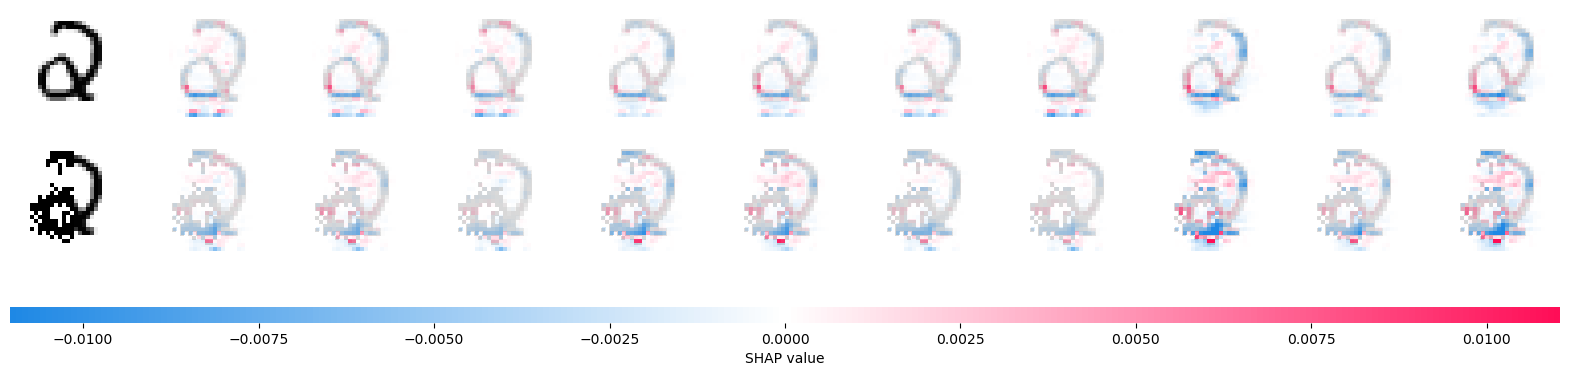

In [408]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv_right]
test_numpy = np.swapaxes(np.swapaxes(lblr_images.numpy(), 1, -1), 1, 2)
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

In [417]:
class score_wrapper(nn.Module):
    def __init__(self, model):
        super(score_wrapper,self).__init__()
        self.model=model

    def forward(self,x):
        x=x.squeeze(1)
        return self.model(x)['y_score'][:,-1,:]
    
swrp= score_wrapper(vmodel)

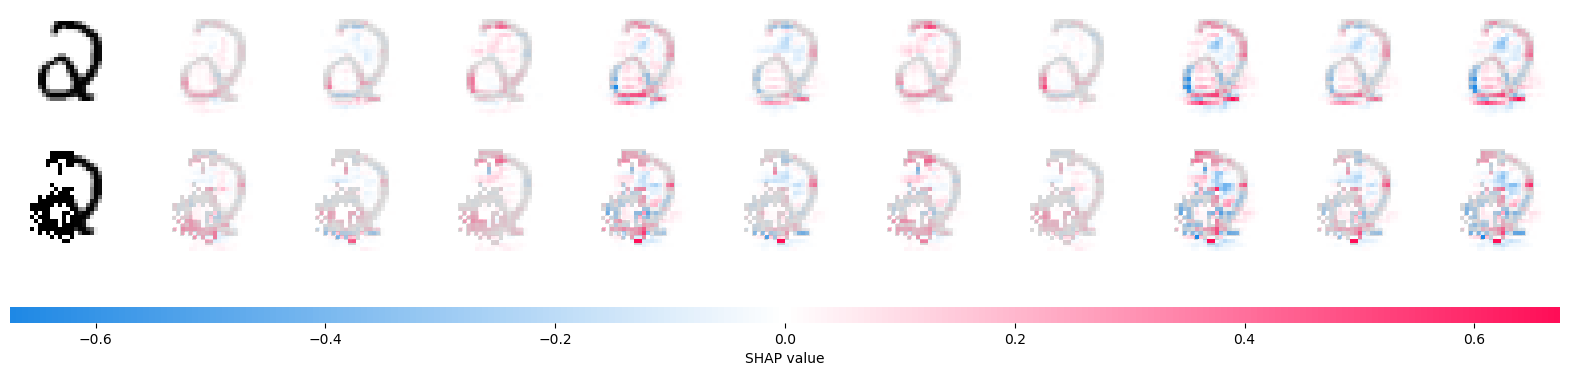

In [418]:
#prediction SHAP
e = shap.GradientExplainer(swrp, background)
shap_values = e.shap_values(lblr_images)
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(lblr_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

In [421]:
#variance of SHAP
shap_values, shap_values_var = e.shap_values(lblr_images, return_variances=True)

In [432]:
print(shap_values_var[0].shape)
print(lblr_images.shape)

(2, 1, 28, 28)
torch.Size([2, 1, 28, 28])


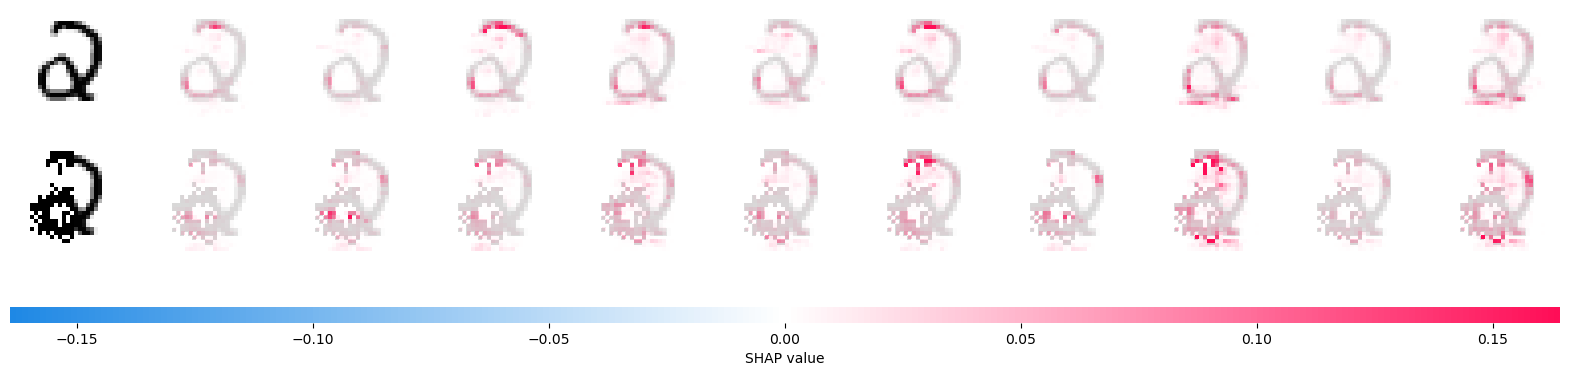

In [434]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_var]
test_numpy = np.swapaxes(np.swapaxes(lblr_images.numpy(), 1, -1), 1, 2)
shap.image_plot(shap_numpy, -test_numpy)

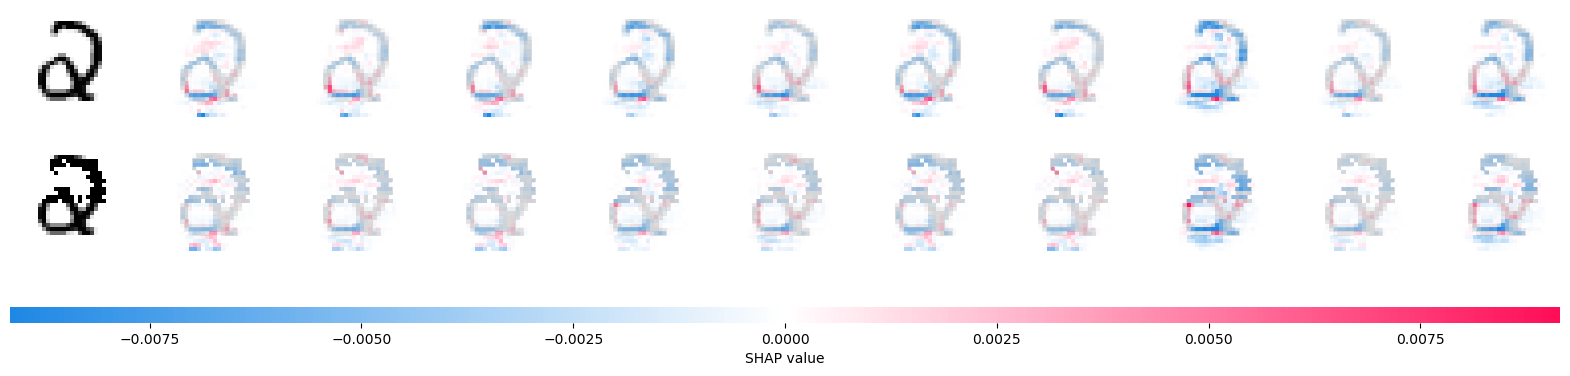

In [409]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv_up]
test_numpy = np.swapaxes(np.swapaxes(upblr_images.numpy(), 1, -1), 1, 2)
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

In [410]:
#attention vs. total variance

In [411]:
_,img_attn=model(upblr_images)
w_numpy = [img_attn.unsqueeze(-1).detach().numpy()]
print(img_attn.shape)
print(len(w_numpy))
print(w_numpy[0].shape)

torch.Size([2, 28, 28])
1
(2, 28, 28, 1)


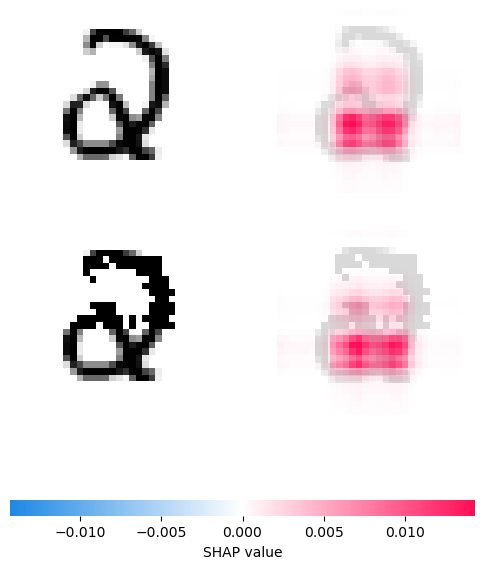

In [412]:
test_numpy = np.swapaxes(np.swapaxes(upblr_images.numpy(), 1, -1), 1, 2)
shap.image_plot(w_numpy, -test_numpy,show=False)


In [413]:
plt.savefig('./RNN_wAttn.png',dpi=300)

<Figure size 640x480 with 0 Axes>

In [414]:
sv_up_total=[np.expand_dims(np.squeeze(np.sum(np.stack(sv_up),axis=0,keepdims=False)), axis=-1)]
print(sv_up_total[0].shape)

(2, 28, 28, 1)


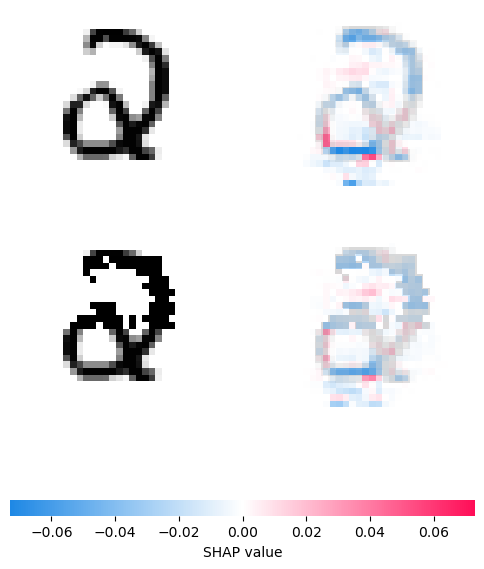

In [415]:
test_numpy = np.swapaxes(np.swapaxes(upblr_images.numpy(), 1, -1), 1, 2)
shap.image_plot(sv_up_total, -test_numpy,show=False)